In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Projects/Brain MRI/data/archive.zip" -d "/content/data/"

In [ ]:
!pip install -r "/content/drive/MyDrive/Projects/Brain MRI/Segmentation/requirements.txt"

In [ ]:
import os
import cv2
import random
import warnings
import pandas as pd
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model, save_model ,Sequential
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import MaxPooling2D, concatenate, Dense, Flatten ,UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


**Loading the dataset**

In [ ]:
mask_files = glob('/content/data/kaggle_3m/*/*_mask*')

In [ ]:
def label(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import os

def process_file(mask_file):
    image_file = mask_file.replace('_mask', '')
    # Check if both files exist
    if os.path.exists(mask_file) and os.path.exists(image_file):
        return image_file, mask_file, label(mask_file)
    else:
        return None

# Lists to store data
images = []
masks = []
labels = []

# Define a function to process each file in parallel
def process_files(mask_files):
    with ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_file, mask_files), total=len(mask_files), desc='Processing files'))

    for result in results:
        if result:
            image, mask, lbl = result
            images.append(image)
            masks.append(mask)
            labels.append(lbl)

# Call the function with your mask files
process_files(mask_files)


Processing files: 100%|██████████| 3929/3929 [00:02<00:00, 1341.64it/s]


In [ ]:
# Create DataFrame
df = pd.DataFrame({
    "image": images,
    "mask": masks,
    "label": labels
})

In [ ]:
df.head()

image  \
0  /content/data/kaggle_3m/TCGA_FG_7643_20021104/...   
1  /content/data/kaggle_3m/TCGA_FG_7643_20021104/...   
2  /content/data/kaggle_3m/TCGA_FG_7643_20021104/...   
3  /content/data/kaggle_3m/TCGA_FG_7643_20021104/...   
4  /content/data/kaggle_3m/TCGA_FG_7643_20021104/...   

                                                mask label  
0  /content/data/kaggle_3m/TCGA_FG_7643_20021104/...     0  
1  /content/data/kaggle_3m/TCGA_FG_7643_20021104/...     0  
2  /content/data/kaggle_3m/TCGA_FG_7643_20021104/...     0  
3  /content/data/kaggle_3m/TCGA_FG_7643_20021104/...     0  
4  /content/data/kaggle_3m/TCGA_FG_7643_20021104/...     1

In [ ]:
df.shape

(3929, 3)

In [ ]:
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3929 non-null   object
 1   mask    3929 non-null   object
 2   label   3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


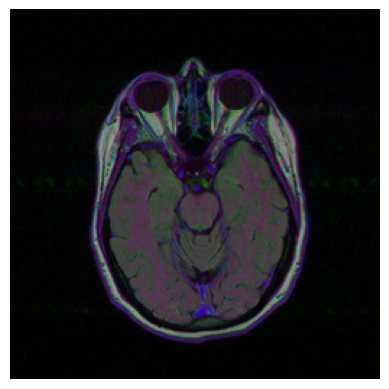

(256, 256)

In [ ]:
import imageio
from PIL import Image

# Open the image file
image_path = df['image'][0]
with Image.open(f"{image_path}") as img:
    plt.imshow(img)
    plt.axis('off') # to turn off axes
    plt.show()

IMG_SIZE = img.size
IMG_SIZE

In [ ]:
IMG_SIZE = img.size
IMG_SIZE

(256, 256)

**Class Distribution**

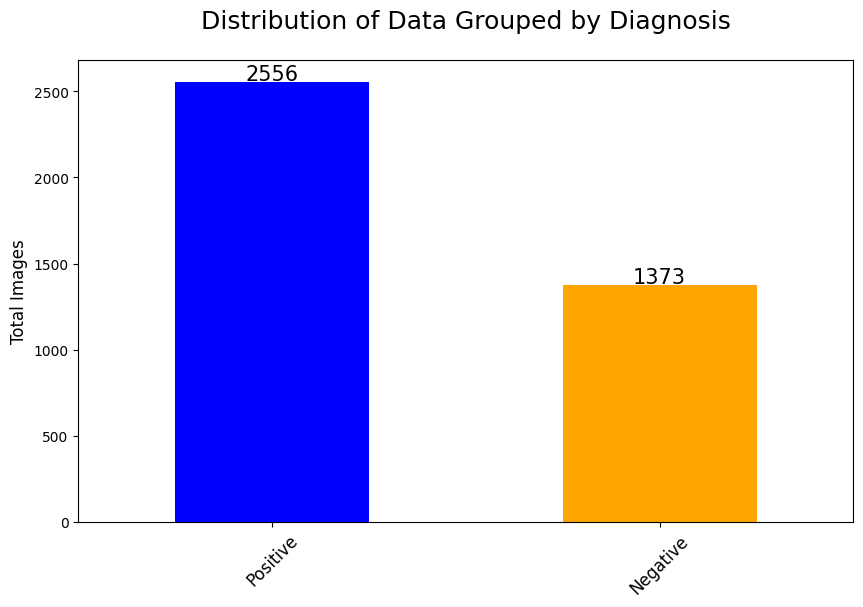

In [ ]:
counts = df['label'].value_counts()
colors = ["blue", "orange"]
labels = ["Positive", "Negative"]

ax = counts.plot.bar(stacked=True, figsize=(10, 6), color=colors)
ax.set_xticklabels(labels, rotation=45, fontsize=12)
ax.set_ylabel("Total Images", fontsize=12)
ax.set_title("Distribution of Data Grouped by Diagnosis", fontsize=18, y=1.05)

for i, count in enumerate(counts):
    ax.annotate(int(count), xy=(i, count+10), color="black", ha="center", fontsize=15)

plt.show()


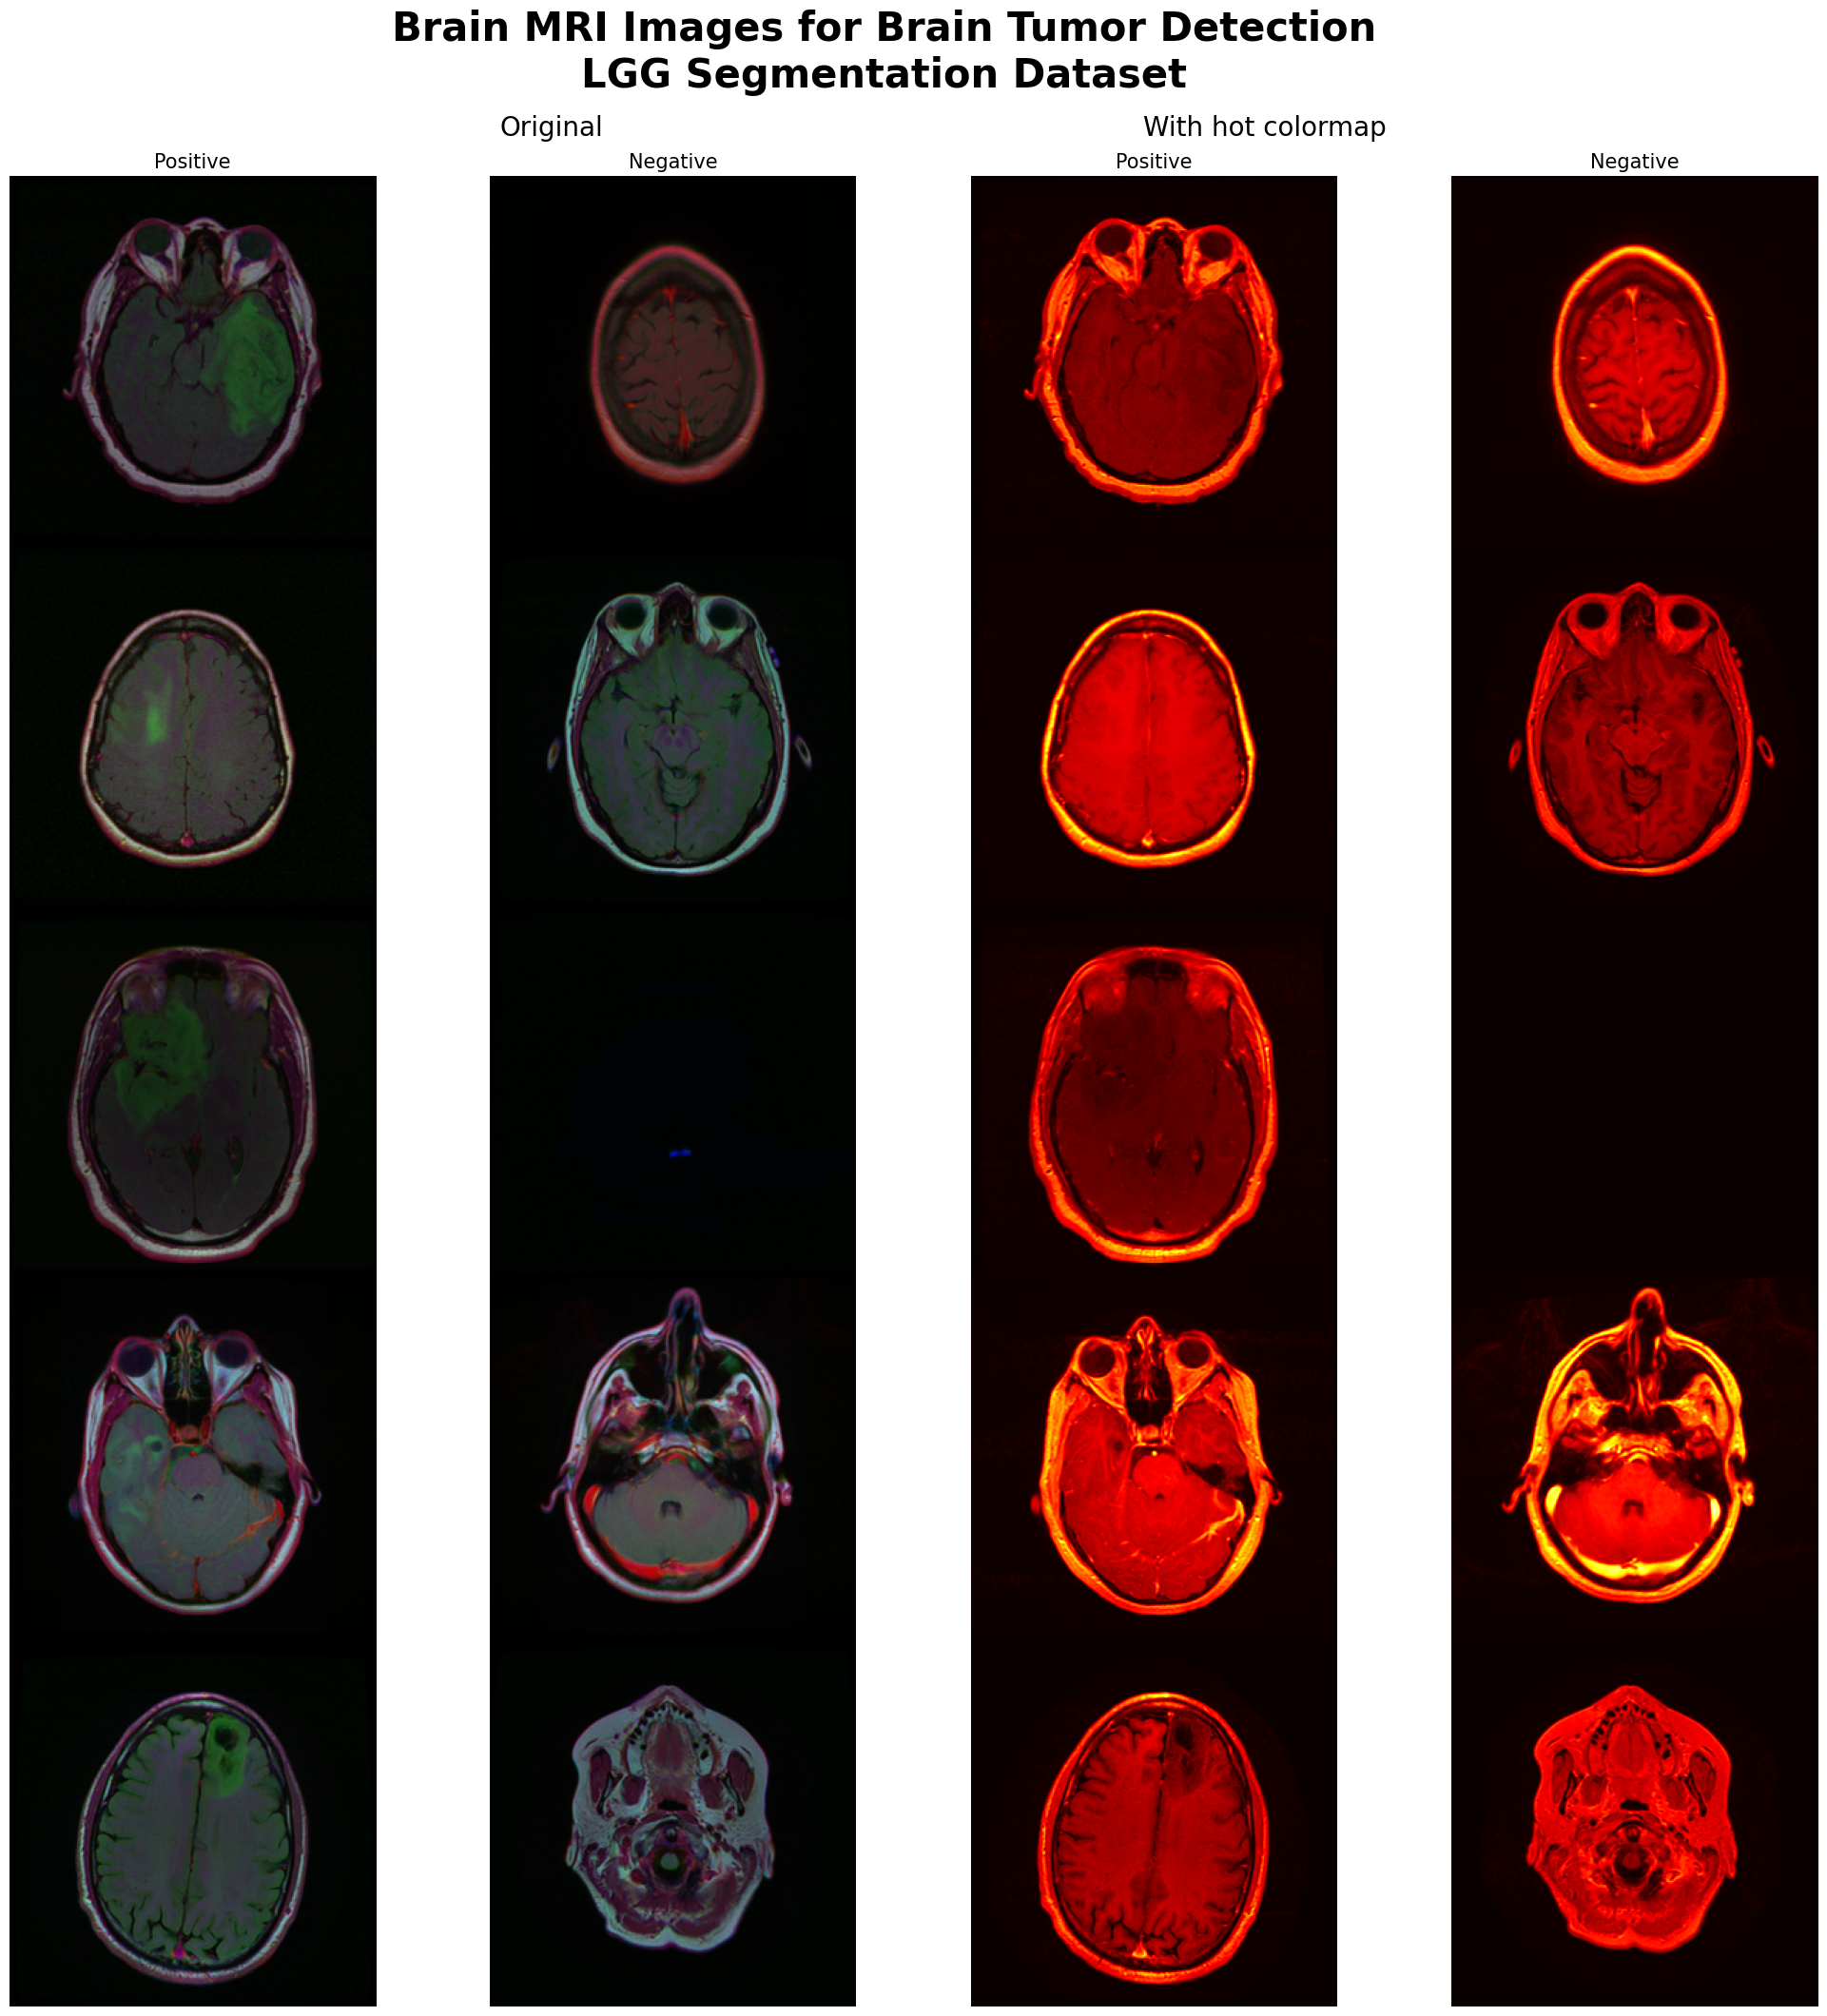

In [ ]:
sample_pos = df[df["label"] == 1].sample(5).image.values
sample_neg = df[df["label"] == 0].sample(5).image.values

sample_imgs = {'Positive': [], 'Negative': []}

for pos, neg in zip(sample_pos, sample_neg):
    sample_imgs['Positive'].append(cv2.resize(cv2.imread(pos), IMG_SIZE))
    sample_imgs['Negative'].append(cv2.resize(cv2.imread(neg), IMG_SIZE))

sample_yes_arr = np.vstack(sample_imgs['Positive'])
sample_no_arr = np.vstack(sample_imgs['Negative'])

# Plot
fig, axs = plt.subplots(1, 4, figsize=(25, 25))

for i, (label, arr, cmap) in enumerate(zip(['Positive', 'Negative'] * 2,
                                           [sample_yes_arr, sample_no_arr] * 2,
                                           [None, None, "hot", "hot"])):
    axs[i].imshow(arr if cmap is None else arr[:,:,0], cmap=cmap)
    axs[i].set_title(label, fontsize=15)
    axs[i].axis("off")

# Annotations
plt.figtext(0.36, 0.90, "Original", va="center", ha="center", size=20)
plt.figtext(0.66, 0.90, "With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# Save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()


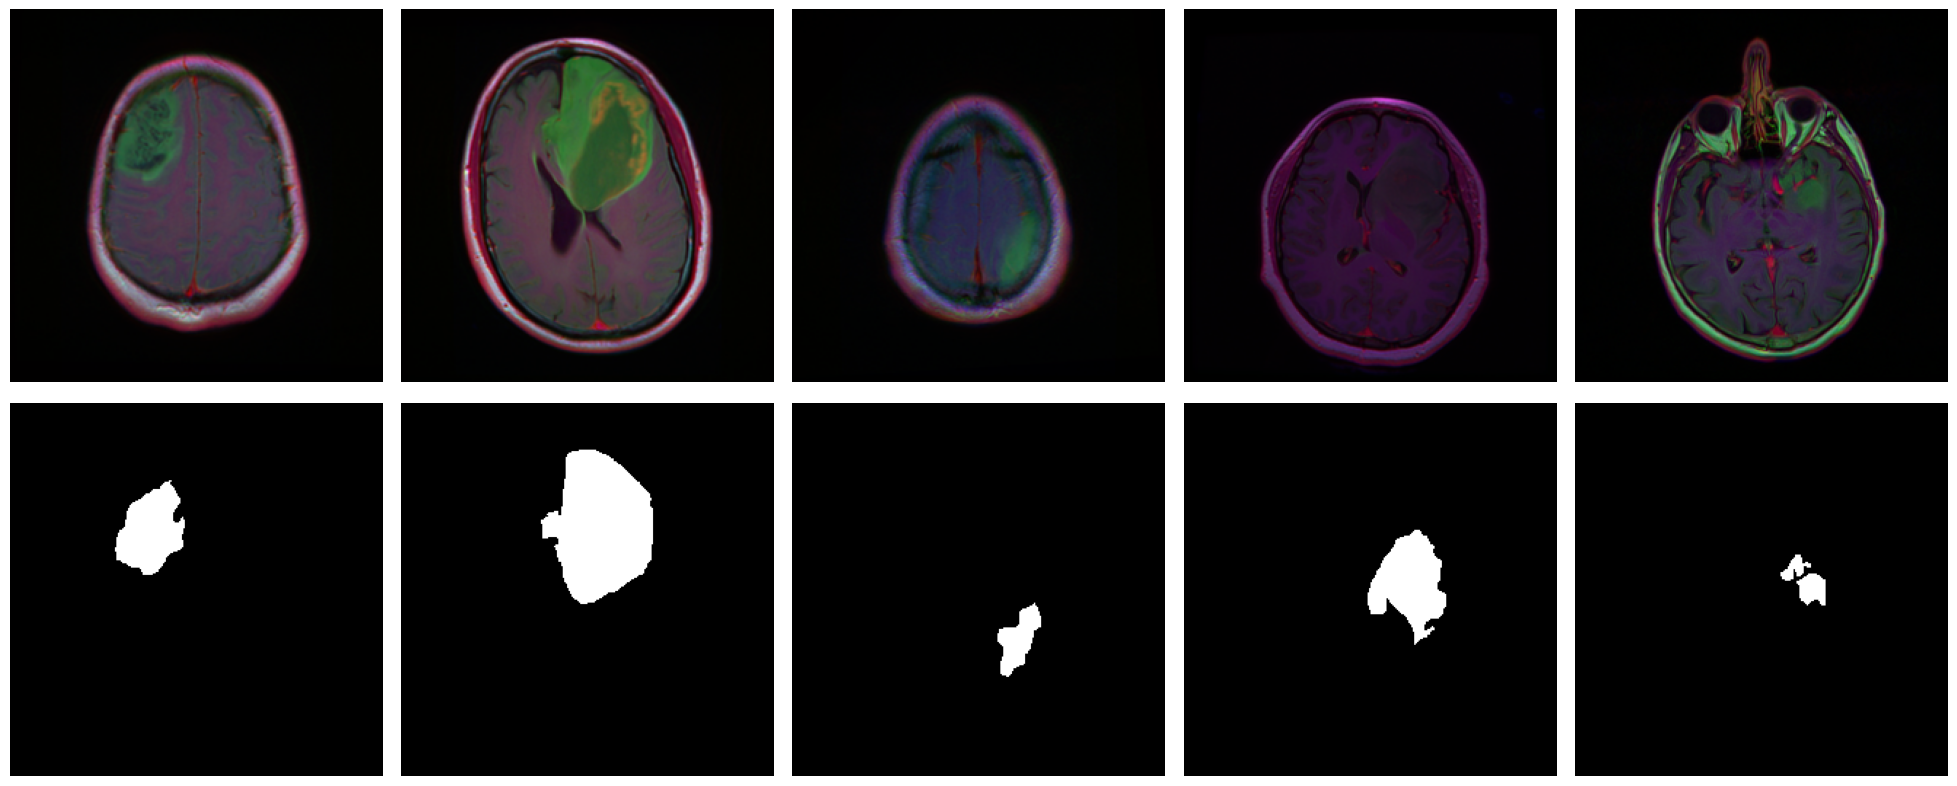

In [ ]:
# Sample images with positive diagnosis
sample_df = df[df["label"] == 1].sample(5)

fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for idx, (index, row) in enumerate(sample_df.iterrows()):
    img = cv2.resize(cv2.imread(row['image']), IMG_SIZE)
    mask = cv2.resize(cv2.imread(row['mask']), IMG_SIZE)

    axs[0, idx].imshow(img)
    axs[0, idx].axis("off")

    axs[1, idx].imshow(mask)
    axs[1, idx].axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


## **Training UNET**

## **Train Test Validation Split**

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.3)
df_test, df_val = train_test_split(df_test, test_size=0.5)

print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2750, 3)
(590, 3)
(589, 3)


In [ ]:
BATCH_SIZE = 16

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        # print("Image shape:", img.shape)
        # print("Mask shape:", mask.shape)
        yield (img, mask[..., np.newaxis])

In [ ]:
def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [ ]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMG_SIZE)

val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMG_SIZE)

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
def build_unet_model():
  with tf.device('/GPU:0'):
    # inputs
    inputs = layers.Input(shape=(256,256,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [ ]:
with tf.device('/GPU:0'):
    unet_model = build_unet_model()
    unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="binary_crossentropy",
                   metrics="accuracy")

In [ ]:
NUM_EPOCHS = 50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early Stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)

# Model Checkpoint to save the best model weights
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/Projects/Brain Tumor/Segmentation/checkpoints/UNET/best_unet_weights.h5",
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)

# Reduce learning rate when val_loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)




In [ ]:
# # Training the model with the callbacks
# history = unet_model.fit(train_gen,
#                          steps_per_epoch=len(df_train) // BATCH_SIZE,
#                          epochs=NUM_EPOCHS,
#                          callbacks=[early_stopping, model_checkpoint, reduce_lr],
#                          validation_data=val_gen,
#                          validation_steps=len(df_val) // BATCH_SIZE,
#                          verbose=1)

Epoch 1/50
171/171 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9904Found 590 validated image filenames.
Found 590 validated image filenames.

Epoch 1: val_loss improved from inf to 0.02788, saving model to best_unet_weights.h5
171/171 [==============================] - 210s 1s/step - loss: 0.1083 - accuracy: 0.9904 - val_loss: 0.0279 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 2/50
171/171 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9919
Epoch 2: val_loss improved from 0.02788 to 0.02715, saving model to best_unet_weights.h5
171/171 [==============================] - 190s 1s/step - loss: 0.0273 - accuracy: 0.9919 - val_loss: 0.0272 - val_accuracy: 0.9924 - lr: 0.0010
Epoch 3/50
171/171 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9922
Epoch 3: val_loss improved from 0.02715 to 0.02593, saving model to best_unet_weights.h5
171/171 [==============================] - 185s 1s/step - loss: 0.0268 - accuracy: 0.

**Learning Curves**

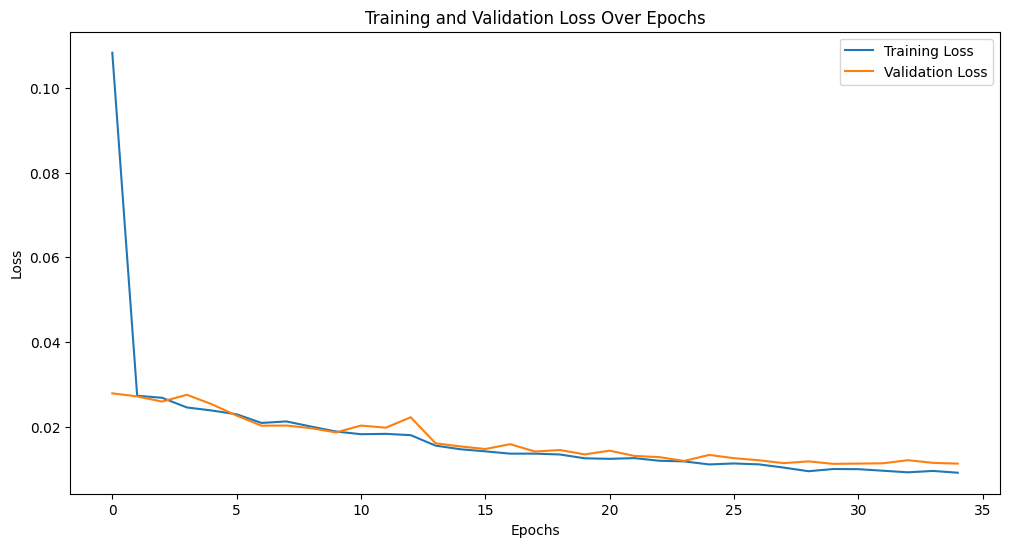

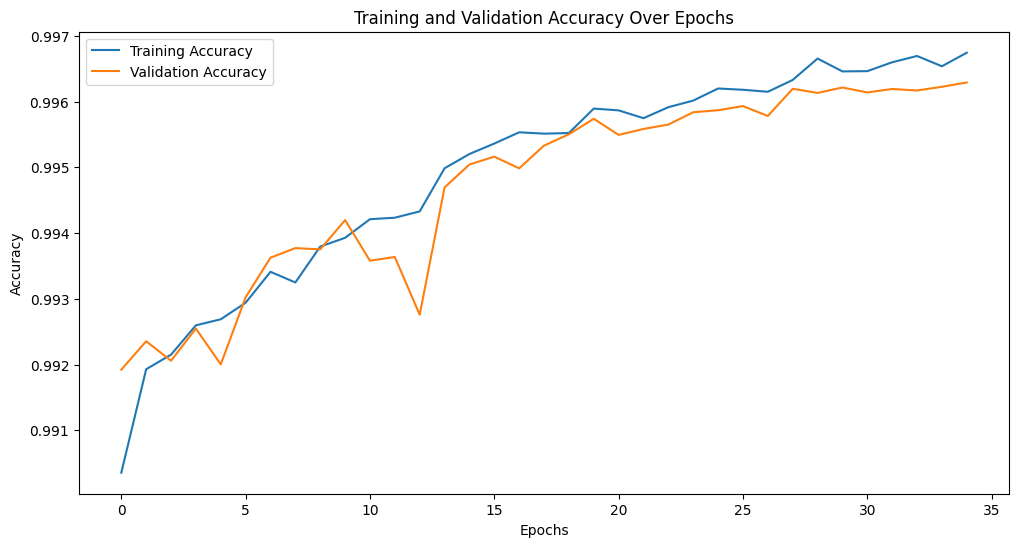

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Testing

In [ ]:
# Build the model architecture
model = build_unet_model()

# Load the saved weights
model.load_weights(r"/content/drive/MyDrive/Projects/Brain MRI/Segmentation/checkpoints/UNET/best_unet_weights.h5")


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [ ]:
BATCH_SIZE = 16
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=IMG_SIZE) # Assuming df_test is defined

## **Model Evaluation**

In [ ]:
# Containers for metrics
iou_scores = []
pixel_accuracies = []
f1_scores = []

STEPS = (len(df_test) + BATCH_SIZE - 1) // BATCH_SIZE
for batch_index in tqdm(range(STEPS)):
    images, masks = next(test_gen)
    numpy_images = images if isinstance(images, np.ndarray) else np.array(images)
    numpy_masks = masks if isinstance(masks, np.ndarray) else np.array(masks)

    # Predict masks
    predicted_masks = unet_model.predict(numpy_images)

    # Threshold the predicted masks
    threshold = 0.5
    predicted_masks_single_channel = (predicted_masks > threshold).astype(np.uint8)
    test_masks_single_channel = numpy_masks[..., 0] if numpy_masks.shape[-1] == 1 else numpy_masks.astype(np.uint8)

    # Calculate pixel accuracy
    pixel_accuracy = accuracy_score(test_masks_single_channel.flatten(), predicted_masks_single_channel.flatten())
    pixel_accuracies.append(pixel_accuracy)

    # Calculate IoU and F1 scores for each image
    for i in range(len(numpy_masks)):
        iou_scores.append(calculate_iou(test_masks_single_channel[i], predicted_masks_single_channel[i]))
        f1_scores.append(f1_score(test_masks_single_channel[i].flatten(), predicted_masks_single_channel[i].flatten()))


  0%|          | 0/37 [00:00<?, ?it/s]

1/1 [==============================] - 34s 34s/step


  3%|▎         | 1/37 [00:41<25:08, 41.90s/it]

1/1 [==============================] - 34s 34s/step


  5%|▌         | 2/37 [01:23<24:26, 41.90s/it]

1/1 [==============================] - 37s 37s/step


  8%|▊         | 3/37 [02:01<22:42, 40.06s/it]

1/1 [==============================] - 35s 35s/step


 11%|█         | 4/37 [02:43<22:21, 40.66s/it]

1/1 [==============================] - 34s 34s/step


 14%|█▎        | 5/37 [03:24<21:52, 41.00s/it]

1/1 [==============================] - 34s 34s/step


 16%|█▌        | 6/37 [03:59<20:08, 38.97s/it]

1/1 [==============================] - 39s 39s/step


 19%|█▉        | 7/37 [04:41<19:58, 39.94s/it]

1/1 [==============================] - 34s 34s/step


 22%|██▏       | 8/37 [05:16<18:29, 38.26s/it]

1/1 [==============================] - 41s 41s/step


 24%|██▍       | 9/37 [05:58<18:21, 39.33s/it]

1/1 [==============================] - 34s 34s/step


 27%|██▋       | 10/37 [06:32<16:59, 37.76s/it]

1/1 [==============================] - 37s 37s/step


 30%|██▉       | 11/37 [07:10<16:21, 37.74s/it]

1/1 [==============================] - 37s 37s/step


 32%|███▏      | 12/37 [07:48<15:44, 37.79s/it]

1/1 [==============================] - 33s 33s/step


 35%|███▌      | 13/37 [08:29<15:34, 38.94s/it]

1/1 [==============================] - 33s 33s/step


 38%|███▊      | 14/37 [09:03<14:23, 37.56s/it]

1/1 [==============================] - 36s 36s/step


 41%|████      | 15/37 [09:45<14:13, 38.79s/it]

1/1 [==============================] - 40s 40s/step


 43%|████▎     | 16/37 [10:26<13:47, 39.42s/it]

1/1 [==============================] - 33s 33s/step


 46%|████▌     | 17/37 [11:00<12:34, 37.73s/it]

1/1 [==============================] - 35s 35s/step


 49%|████▊     | 18/37 [11:35<11:44, 37.10s/it]

1/1 [==============================] - 35s 35s/step


 51%|█████▏    | 19/37 [12:17<11:32, 38.46s/it]

1/1 [==============================] - 33s 33s/step


 54%|█████▍    | 20/37 [12:59<11:09, 39.41s/it]

1/1 [==============================] - 34s 34s/step


 57%|█████▋    | 21/37 [13:40<10:41, 40.07s/it]

1/1 [==============================] - 35s 35s/step


 59%|█████▉    | 22/37 [14:22<10:08, 40.53s/it]

1/1 [==============================] - 36s 36s/step


 62%|██████▏   | 23/37 [15:04<09:32, 40.86s/it]

1/1 [==============================] - 33s 33s/step


 65%|██████▍   | 24/37 [15:45<08:54, 41.09s/it]

1/1 [==============================] - 35s 35s/step


 68%|██████▊   | 25/37 [16:27<08:15, 41.25s/it]

1/1 [==============================] - 34s 34s/step


 70%|███████   | 26/37 [17:08<07:35, 41.37s/it]

1/1 [==============================] - 35s 35s/step


 73%|███████▎  | 27/37 [17:44<06:36, 39.62s/it]

1/1 [==============================] - 33s 33s/step


 76%|███████▌  | 28/37 [18:17<05:39, 37.72s/it]

1/1 [==============================] - 35s 35s/step


 78%|███████▊  | 29/37 [18:59<05:11, 38.89s/it]

1/1 [==============================] - 34s 34s/step


 81%|████████  | 30/37 [19:40<04:37, 39.71s/it]

1/1 [==============================] - 41s 41s/step


 84%|████████▍ | 31/37 [20:22<04:02, 40.38s/it]

1/1 [==============================] - 34s 34s/step


 86%|████████▋ | 32/37 [20:57<03:12, 38.56s/it]

1/1 [==============================] - 35s 35s/step


 89%|████████▉ | 33/37 [21:32<02:30, 37.68s/it]

1/1 [==============================] - 33s 33s/step


 92%|█████████▏| 34/37 [22:06<01:49, 36.53s/it]

1/1 [==============================] - 30s 30s/step


 95%|█████████▍| 35/37 [22:48<01:16, 38.03s/it]

1/1 [==============================] - 35s 35s/step


 97%|█████████▋| 36/37 [23:23<00:37, 37.30s/it]

1/1 [==============================] - 33s 33s/step


100%|██████████| 37/37 [23:57<00:00, 38.85s/it]


In [ ]:
 average_iou = np.mean(iou_scores)
average_f1 = np.mean(f1_scores)
average_pixel_accuracy = np.mean(pixel_accuracies)

print("Pixel Accuracy:", average_pixel_accuracy)
print("Average IoU Score:", average_iou)
print("Average F1 Score:", average_f1)

Pixel Accuracy: 0.9668690786540136
Average IoU Score: 2.146149395683794e-05
Average F1 Score: 4.286648331602614e-05
